## ライブラリインポート

In [1]:
import os
import gc
import numpy as np
import random
from time import time

import pandas as pd
pd.options.display.precision = 2

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statistics import mean, stdev

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

## ランダムシードの固定

In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    # Tensorflow
    #tf.random.set_seed(seed)

SEED = 42
fix_seed(SEED)

## モデルインポート

In [3]:
%%capture
!pip install catboost

In [4]:
# https://qiita.com/futakuchi0117/items/72ce4afae9adcccd6e18

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

model_list = [
    DummyRegressor(),
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(), 
    #Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())]),
    #Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())]),
    #Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression())]),
    #Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression())]),
    KNeighborsRegressor(n_neighbors=3),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1),
    GaussianProcessRegressor(),
    #SGDRegressor(),
    MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, early_stopping=True, n_iter_no_change=5),
    ExtraTreesRegressor(n_estimators=100), 
    #PLSRegression(n_components=10),
    #PassiveAggressiveRegressor(max_iter=100, tol=1e-3),
    #TheilSenRegressor(random_state=SEED),
    #RANSACRegressor(random_state=SEED),
    #HistGradientBoostingRegressor(),
    AdaBoostRegressor(random_state=SEED, n_estimators=100),
    #BaggingRegressor(base_estimator=SVR(), n_estimators=10),
    #GradientBoostingRegressor(random_state=SEED),
    #VotingRegressor([('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=10))]),
    #StackingRegressor(estimators=[('lr', RidgeCV()), ('svr', LinearSVR())], final_estimator=RandomForestRegressor(n_estimators=10)),
    #ARDRegression(),
    #HuberRegressor(),
    xgb.XGBRegressor(n_jobs=-1, random_state=SEED, objective='reg:squarederror'),
    lgb.LGBMRegressor(n_jobs=-1, random_state=SEED),
    cat.CatBoostRegressor(verbose=False, random_state=SEED),
    ]

## データロード

In [5]:
# メモリ削減関数
# https://tellmoogle.hatenablog.com/entry/2020/12/22/faster_reduce_mem_usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    dfs = []
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dfs.append(df[col].astype(np.int8))
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dfs.append(df[col].astype(np.int16))
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dfs.append(df[col].astype(np.int32))
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dfs.append(df[col].astype(np.int64) ) 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dfs.append(df[col].astype(np.float16))
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dfs.append(df[col].astype(np.float32))
                else:
                    dfs.append(df[col].astype(np.float64))
        else:
            dfs.append(df[col])
    
    df_out = pd.concat(dfs, axis=1)

    if verbose:
        end_mem = df_out.memory_usage().sum() / 1024**2
        num_reduction = str(100 * (start_mem - end_mem) / start_mem)
        print(f'Mem. usage decreased to {str(end_mem)[:3]}Mb:  {num_reduction[:2]}% reduction')

    return df_out

In [6]:
# trainデータロード
def load_train():
    _df = pd.read_csv('train.csv')
    
    _df = reduce_mem_usage(_df)
    gc.collect()
    
    return _df

df_train = load_train()

Mem. usage decreased to 0.0Mb:  74% reduction


In [7]:
# testデータロード
def load_test():
    _df = pd.read_csv('test.csv')
    
    _df = reduce_mem_usage(_df)
    gc.collect()
    
    return _df

df_test = load_test()

Mem. usage decreased to 0.0Mb:  74% reduction


In [8]:
# train先頭データ
df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,6.32e-03,18.0,2.31,0.0,0.54,6.57,65.19,4.09,1.0,296.0,15.3,397.00,4.98,24.00
1,2.73e-02,0.0,7.07,0.0,0.47,6.42,78.88,4.97,2.0,242.0,17.8,397.00,9.14,21.59
2,2.73e-02,0.0,7.07,0.0,0.47,7.18,61.09,4.97,2.0,242.0,17.8,392.75,4.03,34.69
3,3.24e-02,0.0,2.18,0.0,0.46,7.00,45.81,6.06,3.0,222.0,18.7,394.75,2.94,33.41
4,6.90e-02,0.0,2.18,0.0,0.46,7.15,54.19,6.06,3.0,222.0,18.7,397.00,5.33,36.19


In [9]:
# test先頭データ
df_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,25.05,0.0,18.09,0.0,0.69,5.99,100.00,1.59,24.0,666.0,20.2,397.0,26.77
1,14.23,0.0,18.09,0.0,0.69,6.34,100.00,1.57,24.0,666.0,20.2,397.0,20.31
2,9.59,0.0,18.09,0.0,0.69,6.40,100.00,1.64,24.0,666.0,20.2,376.0,20.31
3,24.80,0.0,18.09,0.0,0.69,5.35,96.00,1.70,24.0,666.0,20.2,397.0,19.77
4,41.53,0.0,18.09,0.0,0.69,5.53,85.38,1.61,24.0,666.0,20.2,329.5,27.38


In [10]:
# trainデータ情報
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     400 non-null    float16
 1   ZN       400 non-null    float16
 2   INDUS    400 non-null    float16
 3   CHAS     400 non-null    float16
 4   NOX      400 non-null    float16
 5   RM       400 non-null    float16
 6   AGE      400 non-null    float16
 7   DIS      400 non-null    float16
 8   RAD      400 non-null    float16
 9   TAX      400 non-null    float16
 10  PTRATIO  400 non-null    float16
 11  B        400 non-null    float16
 12  LSTAT    400 non-null    float16
 13  price    400 non-null    float16
dtypes: float16(14)
memory usage: 11.1 KB


In [11]:
# testデータ情報
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     100 non-null    float16
 1   ZN       100 non-null    float16
 2   INDUS    100 non-null    float16
 3   CHAS     100 non-null    float16
 4   NOX      100 non-null    float16
 5   RM       100 non-null    float16
 6   AGE      100 non-null    float16
 7   DIS      100 non-null    float16
 8   RAD      100 non-null    float16
 9   TAX      100 non-null    float16
 10  PTRATIO  100 non-null    float16
 11  B        100 non-null    float16
 12  LSTAT    100 non-null    float16
dtypes: float16(13)
memory usage: 2.7 KB


In [12]:
# train統計情報
df_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
count,4.00e+02,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.0,400.00,400.00,400.00,400.00
mean,1.75e+00,14.38,9.41,0.09,0.53,6.34,64.06,4.20,6.62,inf,18.02,inf,11.25,24.34
std,5.99e+00,25.39,6.51,0.28,0.11,0.73,28.98,2.18,6.30,inf,2.22,inf,6.77,9.16
min,6.32e-03,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.0,12.60,70.81,1.73,5.00
25%,6.61e-02,0.00,4.12,0.00,0.44,5.89,37.69,2.34,4.00,276.0,16.59,381.12,6.28,18.91
50%,1.61e-01,0.00,7.02,0.00,0.51,6.23,68.75,3.88,5.00,307.0,18.41,392.50,9.61,22.50
75%,7.32e-01,21.00,13.92,0.00,0.58,6.69,91.88,5.66,6.00,403.0,20.20,396.62,14.48,28.25
max,8.90e+01,100.00,25.66,1.00,0.87,8.78,100.00,12.12,24.00,666.0,22.00,397.00,37.97,50.00


In [13]:
# test統計情報
df_test.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,100.00,100.0,100.00,100.0,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00
mean,11.28,0.0,17.98,0.0,0.65,6.07,85.75,2.26,21.73,649.0,20.12,261.50,18.48
std,12.60,0.0,3.11,0.0,0.06,0.53,16.14,0.59,6.16,inf,0.26,inf,5.62
min,0.11,0.0,9.69,0.0,0.53,4.14,28.80,1.18,4.00,391.0,19.20,0.32,7.01
25%,4.80,0.0,18.09,0.0,0.58,5.76,78.55,1.85,24.00,666.0,20.20,87.05,14.62
50%,7.95,0.0,18.09,0.0,0.66,6.16,92.09,2.12,24.00,666.0,20.20,346.75,17.91
75%,13.23,0.0,18.09,0.0,0.71,6.41,97.91,2.58,24.00,666.0,20.20,393.25,21.66
max,73.56,0.0,27.73,0.0,0.74,7.39,100.00,4.10,24.00,711.0,20.20,397.00,36.97


## 全変数の分布

In [14]:
def plot_all_cols(df):
    num_plot_col = 4
    num_plot_row = round(len(df.columns) / num_plot_col)
    i = 0
    for col in df.columns:
        col_type = df[col].dtypes
        
        if i == 0:
            fig = plt.figure(figsize=(13,2))
            plt.subplots_adjust(wspace=0.8)
            
        ax = fig.add_subplot(1, num_plot_col, i + 1)
        ax.set_title(col)
        if col_type in ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            sns.distplot(df[col], bins=30, kde=False, ax=ax)
        elif col_type in ['bool']:
            sns.countplot(data=df, x=col, ax=ax)
        elif col_type in ['object']:
            sns.countplot(data=df, x=col, ax=ax)
            
        i += 1
        if i == num_plot_col:
            plt.show()
            i = 0

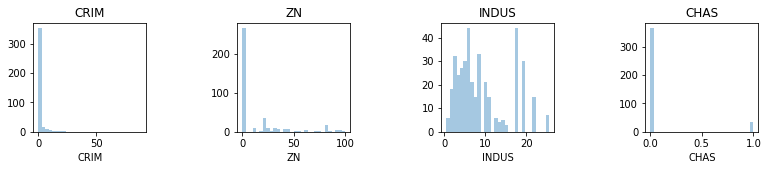

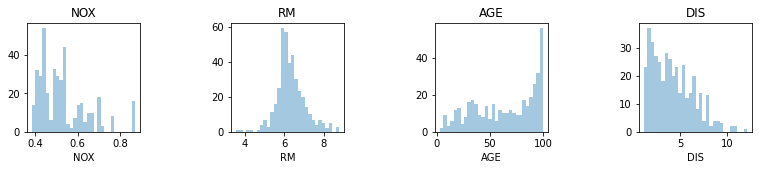

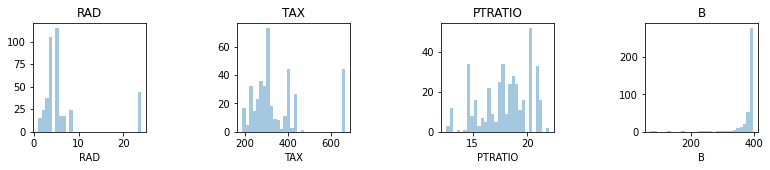

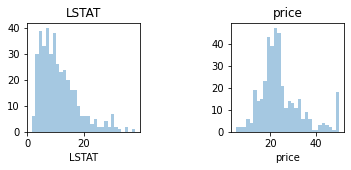

In [15]:
# trainの変数
plot_all_cols(df_train)

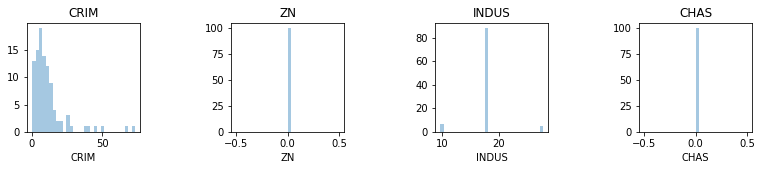

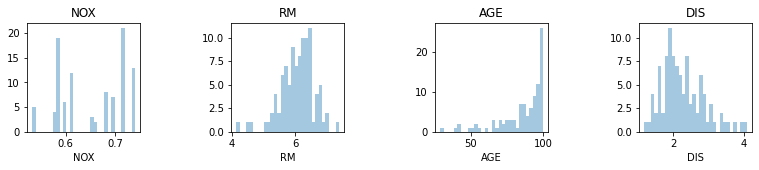

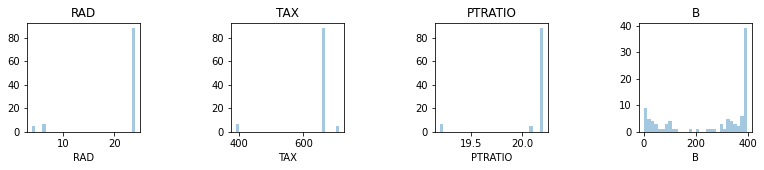

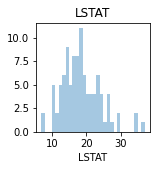

In [16]:
# testの変数
plot_all_cols(df_test)

## 相関係数分析

In [17]:
def corr(df):
    values = 1 - squareform(pdist(df.T, 'correlation'))
    return pd.DataFrame(values, columns=df.columns, index=df.columns)

Text(0.5, 1.0, 'Train')

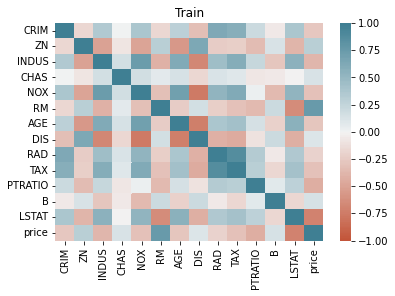

In [18]:
# trainの相関係数ヒートマップ
p = sns.heatmap(corr(df_train), vmax=1, vmin=-1, center=0, cmap=sns.diverging_palette(20, 220, n=200))
p.set_title('Train')

Text(0.5, 1.0, 'Test')

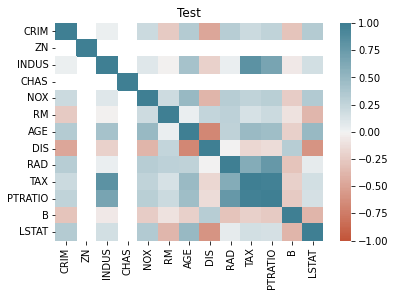

In [19]:
# testの相関係数ヒートマップ
p = sns.heatmap(corr(df_test), vmax=1, vmin=-1, center=0, cmap=sns.diverging_palette(20, 220, n=200))
p.set_title('Test')

## 対一変数プロット

In [20]:
def plot_pair(df, y_label):
    num_plot_col = 4
    num_plot_row = round(len(df.columns) / num_plot_col)
    i = 0
    for col in df.columns:
        col_type = df[col].dtypes
        
        if i == 0:
            fig = plt.figure(figsize=(13,2))
            plt.subplots_adjust(wspace=0.8)
            
        ax = fig.add_subplot(1, num_plot_col, i + 1)
        ax.set_title(col)
        if col_type in ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            sns.scatterplot(data=df, x=col, y=y_label, ax=ax, alpha=0.2)
        elif col_type in ['bool']:
            sns.stripplot(data=df, x=col, y=y_label, ax=ax)
        elif col_type in ['object']:
            sns.stripplot(data=df, x=col, y=y_label, ax=ax)
            
        i += 1
        if i == num_plot_col:
            plt.show()
            i = 0

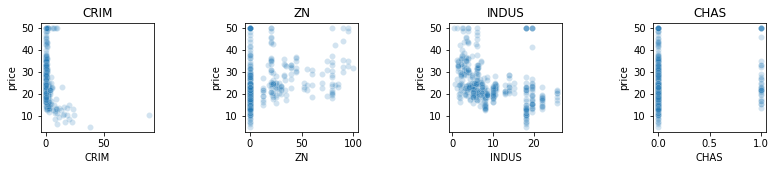

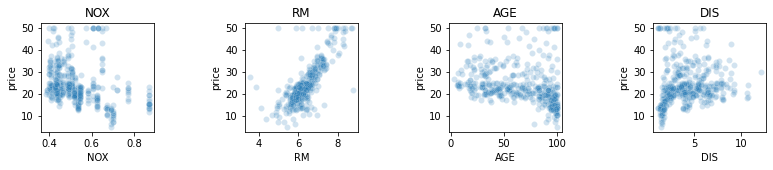

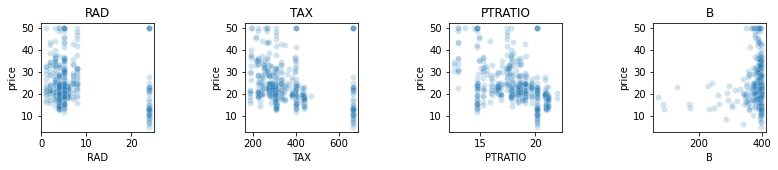

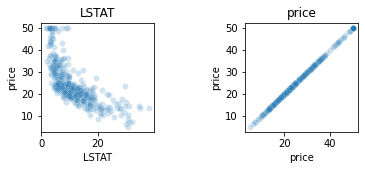

In [21]:
# trainのpriceに対する全変数の散布図
plot_pair(df_train, 'price')

## クロスバリデーション用関数

In [22]:
# CVの分割数
NFOLD = 5

In [23]:
# 評価用関数
def get_scores(y, y_preds):
    scores = {}
    scores['MAE'] = mean_absolute_error(y, y_preds)
    scores['MSE'] = mean_squared_error(y, y_preds)
    scores['RMSE'] = mean_squared_error(y, y_preds, squared=False)
    scores['R2_score'] = r2_score(y, y_preds)
    return scores

In [24]:
# 学習用関数
def Varidation(X_train, X_valid, y_train, y_valid, model):
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    scores_train = get_scores(y_train, y_train_pred)
    
    y_valid_pred = model.predict(X_valid)
    scores_valid = get_scores(y_valid, y_valid_pred)

    return y_train_pred, y_valid_pred, scores_train, scores_valid

In [25]:
# CV用関数
def CrossVaridation(X, y, model):
    time_start = time()
    
    if 'linear_model' in str(type(model)):
        s = StandardScaler()
        X = s.fit_transform(X)
        
    list_y_train_true = []
    list_y_valid_true = []
    list_y_train_pred = []
    list_y_valid_pred = []
    df_scores_train = pd.DataFrame([])
    df_scores_valid = pd.DataFrame([])
    
    kf = KFold(n_splits=NFOLD, shuffle=True, random_state=SEED)
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        list_y_train_true = list_y_train_true + y_train.tolist()
        list_y_valid_true = list_y_valid_true + y_valid.tolist()
        
        y_train_pred, y_valid_pred, scores_train, scores_valid = Varidation(X_train, X_valid, y_train, y_valid, model)
        
        list_y_train_pred = list_y_train_pred + y_train_pred.tolist()
        list_y_valid_pred = list_y_valid_pred + y_valid_pred.tolist()
        df_scores_train = pd.concat([df_scores_train, pd.DataFrame(scores_train,index=[len(df_scores_train)])])
        df_scores_valid = pd.concat([df_scores_valid, pd.DataFrame(scores_valid,index=[len(df_scores_valid)])])

    desc_train = df_scores_train.describe()
    desc_valid = df_scores_valid.describe()
    
    for score in desc_train.columns:
        print('Train {0}: {1:.3f}+/-{2:.3f}'.format(score, desc_train.at['mean', score], desc_train.at['std', score]))
        print('Valid {0}: {1:.3f}+/-{2:.3f}'.format(score, desc_valid.at['mean', score], desc_valid.at['std', score]))
        
    elapsed_time = time() - time_start
    print('Elapsed time: {0:.2f}'.format(elapsed_time))

    #plot
    fig, ax = plt.subplots(figsize=(4, 4))
    sc_train = ax.scatter(list_y_train_true, list_y_train_pred, c='red',  alpha=0.5)
    sc_valid = ax.scatter(list_y_valid_true, list_y_valid_pred, c='blue', alpha=0.5)
    ax.legend([sc_train, sc_valid], ['train', 'valid'], loc='upper left')
    ax.set_title(model.__class__.__name__)
    ax.set_xlabel('true')
    ax.set_ylabel('pred')
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()

Model: DummyRegressor
Train MAE: 6.758+/-0.285
Valid MAE: 6.773+/-0.847
Train MSE: 83.750+/-5.703
Valid MSE: 84.312+/-23.125
Train RMSE: 9.141+/-0.317
Valid RMSE: 9.117+/-1.220
Train R2_score: 0.000+/-0.000
Valid R2_score: -0.015+/-0.016
Elapsed time: 0.07


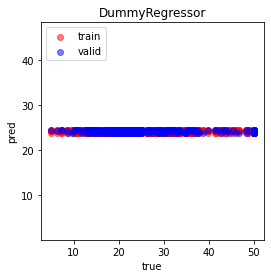

---
Model: LinearRegression
Train MAE: 3.259+/-0.154
Valid MAE: 3.407+/-0.288
Train MSE: 22.097+/-2.036
Valid MSE: 24.413+/-8.001
Train RMSE: 4.697+/-0.216
Valid RMSE: 4.885+/-0.826
Train R2_score: 0.736+/-0.017
Valid R2_score: 0.704+/-0.082
Elapsed time: 0.08


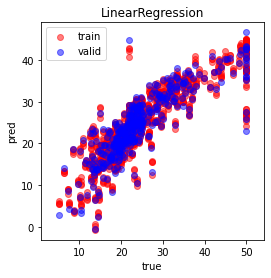

---
Model: Ridge
Train MAE: 3.254+/-0.153
Valid MAE: 3.394+/-0.299
Train MSE: 22.099+/-2.036
Valid MSE: 24.343+/-8.123
Train RMSE: 4.697+/-0.216
Valid RMSE: 4.876+/-0.842
Train R2_score: 0.736+/-0.017
Valid R2_score: 0.705+/-0.082
Elapsed time: 0.08


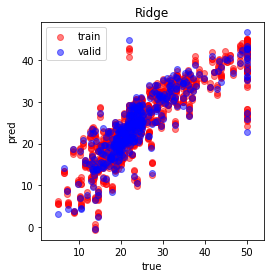

---
Model: Lasso
Train MAE: 3.685+/-0.139
Valid MAE: 3.718+/-0.440
Train MSE: 29.185+/-2.371
Valid MSE: 30.289+/-11.185
Train RMSE: 5.399+/-0.220
Valid RMSE: 5.425+/-1.035
Train R2_score: 0.652+/-0.016
Valid R2_score: 0.640+/-0.078
Elapsed time: 0.09


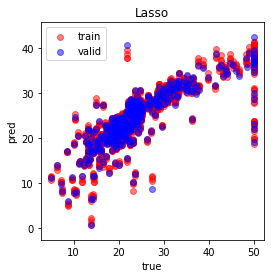

---
Model: ElasticNet
Train MAE: 3.840+/-0.123
Valid MAE: 3.890+/-0.489
Train MSE: 31.020+/-2.276
Valid MSE: 32.435+/-12.101
Train RMSE: 5.567+/-0.205
Valid RMSE: 5.617+/-1.054
Train R2_score: 0.629+/-0.015
Valid R2_score: 0.616+/-0.064
Elapsed time: 0.07


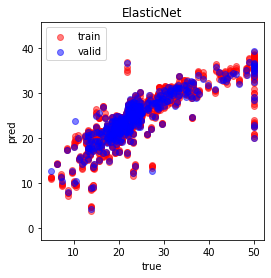

---
Model: KNeighborsRegressor
Train MAE: 3.262+/-0.205
Valid MAE: 4.805+/-0.704
Train MSE: 23.375+/-2.822
Valid MSE: 48.438+/-12.180
Train RMSE: 4.828+/-0.295
Valid RMSE: 6.918+/-0.867
Train R2_score: 0.721+/-0.025
Valid R2_score: 0.412+/-0.066
Elapsed time: 0.09


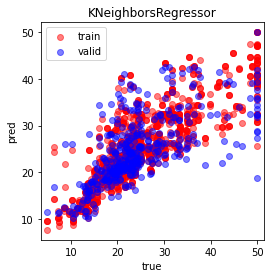

---
Model: DecisionTreeRegressor
Train MAE: 0.000+/-0.000
Valid MAE: 2.995+/-0.554
Train MSE: 0.000+/-0.000
Valid MSE: 24.264+/-17.660
Train RMSE: 0.000+/-0.000
Valid RMSE: 4.721+/-1.572
Train R2_score: 1.000+/-0.000
Valid R2_score: 0.727+/-0.119
Elapsed time: 0.11


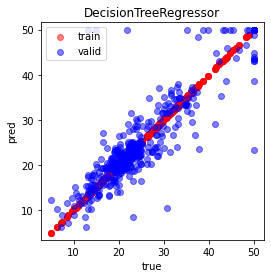

---
Model: RandomForestRegressor
Train MAE: 0.835+/-0.029
Valid MAE: 2.173+/-0.216
Train MSE: 1.766+/-0.242
Valid MSE: 11.215+/-4.066
Train RMSE: 1.327+/-0.091
Valid RMSE: 3.306+/-0.596
Train R2_score: 0.979+/-0.004
Valid R2_score: 0.864+/-0.038
Elapsed time: 2.78


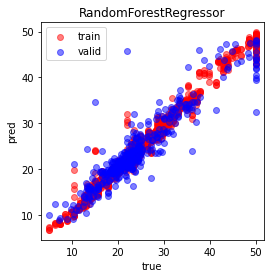

---
Model: SVR
Train MAE: 0.099+/-0.000
Valid MAE: 6.233+/-0.780
Train MSE: 0.010+/-0.000
Valid MSE: 73.672+/-20.879
Train RMSE: 0.099+/-0.000
Valid RMSE: 8.521+/-1.152
Train R2_score: 1.000+/-0.000
Valid R2_score: 0.112+/-0.061
Elapsed time: 0.33


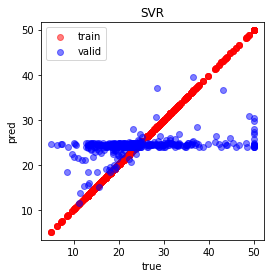

---
Model: GaussianProcessRegressor
Train MAE: 0.000+/-0.000
Valid MAE: 23.931+/-1.050
Train MSE: 0.000+/-0.000
Valid MSE: 660.856+/-74.331
Train RMSE: 0.000+/-0.000
Valid RMSE: 25.676+/-1.421
Train R2_score: 1.000+/-0.000
Valid R2_score: -7.222+/-1.282
Elapsed time: 0.55


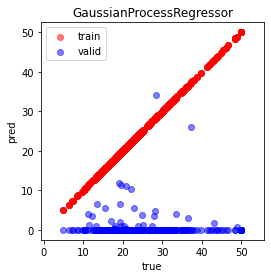

---
Model: MLPRegressor
Train MAE: 8.058+/-2.029
Valid MAE: 7.945+/-1.406
Train MSE: 124.792+/-62.362
Valid MSE: 118.234+/-37.935
Train RMSE: 10.901+/-2.729
Valid RMSE: 10.754+/-1.799
Train R2_score: -0.472+/-0.677
Valid R2_score: -0.494+/-0.609
Elapsed time: 1.68


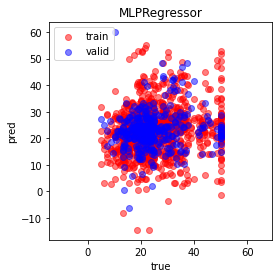

---
Model: ExtraTreesRegressor
Train MAE: 0.000+/-0.000
Valid MAE: 2.036+/-0.258
Train MSE: 0.000+/-0.000
Valid MSE: 9.435+/-4.005
Train RMSE: 0.000+/-0.000
Valid RMSE: 3.018+/-0.640
Train R2_score: 1.000+/-0.000
Valid R2_score: 0.884+/-0.051
Elapsed time: 2.56


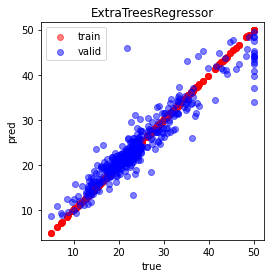

---
Model: AdaBoostRegressor
Train MAE: 2.127+/-0.092
Valid MAE: 2.595+/-0.321
Train MSE: 6.554+/-0.463
Valid MSE: 12.618+/-4.292
Train RMSE: 2.559+/-0.090
Valid RMSE: 3.510+/-0.611
Train R2_score: 0.921+/-0.010
Valid R2_score: 0.846+/-0.050
Elapsed time: 1.85


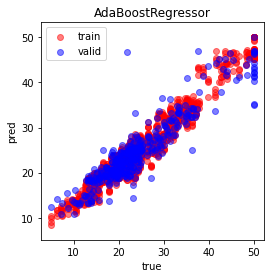

---
Model: XGBRegressor
Train MAE: 0.980+/-0.035
Valid MAE: 2.148+/-0.279
Train MSE: 1.666+/-0.135
Valid MSE: 10.379+/-4.252
Train RMSE: 1.290+/-0.052
Valid RMSE: 3.169+/-0.646
Train R2_score: 0.980+/-0.003
Valid R2_score: 0.876+/-0.037
Elapsed time: 2.33


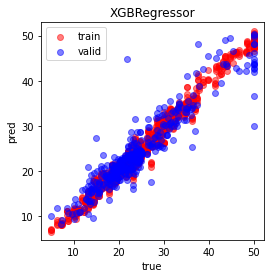

---
Model: LGBMRegressor
Train MAE: 0.971+/-0.035
Valid MAE: 2.212+/-0.174
Train MSE: 2.627+/-0.364
Valid MSE: 11.801+/-4.397
Train RMSE: 1.618+/-0.113
Valid RMSE: 3.389+/-0.627
Train R2_score: 0.968+/-0.006
Valid R2_score: 0.852+/-0.064
Elapsed time: 0.26


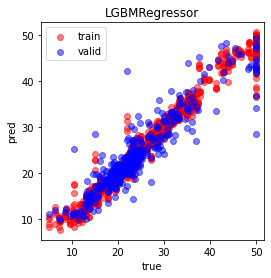

---
Model: CatBoostRegressor
Train MAE: 0.307+/-0.019
Valid MAE: 2.002+/-0.238
Train MSE: 0.153+/-0.023
Valid MSE: 9.124+/-3.481
Train RMSE: 0.390+/-0.029
Valid RMSE: 2.978+/-0.563
Train R2_score: 0.998+/-0.000
Valid R2_score: 0.891+/-0.028
Elapsed time: 9.67


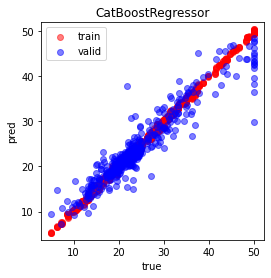

---


In [26]:
X = df_train.drop(columns=['price']).values
y = df_train['price'].values
for model in model_list:
    print(f'Model: {model.__class__.__name__}')
    CrossVaridation(X, y, model)
    print('---')